***UNZIP THE IMOCAP DATASETS***

*PREPROCESIING THE IMPCAP AUDIO FILES* : THANKS TO ***https://github.com/MITESHPUTHRANNEU/Speech-Emotion-Analyzer/blob/master/final_results_gender_test.ipynb  and https://github.com/david-yoon/multimodal-speech-emotion/blob/master/preprocessing/IEMOCAP_01_wav_to_feature.ipynb 

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.backend_bases import RendererBase
from scipy import signal
from scipy.io import wavfile
import os
from PIL import Image
from scipy.fftpack import fft
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms


/home/kovan2/anaconda3/envs/ser/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn(


**read the all the files in a list at sentence level**

In [2]:
import os
import chardet

def file_search(dirname, ret, list_avoid_dir=[]):
    filenames = os.listdir(dirname)
    
    for filename in filenames:
        full_filename = os.path.join(dirname, filename)

        if os.path.isdir(full_filename) :
            if full_filename.split('/')[-1] in list_avoid_dir:
                continue
            else:
                file_search(full_filename, ret, list_avoid_dir)
            
        else:
            ret.append( full_filename ) 

In [3]:
list_files = []
for x in range(5):
    sess_name = 'Session' + str(x+1)
    path = '/home/kovan2/Desktop/ser/iemocap/IEMOCAP_full_release/'+ sess_name + '/sentences/wav/'
    file_search(path, list_files)
    list_files = sorted(list_files)
    print (sess_name + ", #sum files: " + str(len(list_files)))
#extract_feature( list_files, out_file )

Session1, #sum files: 1820
Session2, #sum files: 3633
Session3, #sum files: 5769
Session4, #sum files: 7873
Session5, #sum files: 10043


***below code is:***
https://github.com/Escanor1996/Speech-Emotion-Recognition-SER-/blob/master/SER.ipynb

***Paper:*** Attention Based Fully Convolutional Network for Speech Emotion Recognition


In [4]:
def audio2spectrogram(filepath):
    #fig = plt.figure(figsize=(5,5))
    samplerate, test_sound  = wavfile.read(filepath,mmap=True)
    #print('samplerate',samplerate)
    _, spectrogram = log_specgram(test_sound, samplerate)
    #print(spectrogram.shape)
    #print(type(spectrogram))
    #plt.imshow(spectrogram.T, aspect='auto', origin='lower')
    return spectrogram
    
def audio2wave(filepath):
    fig = plt.figure(figsize=(5,5))
    samplerate, test_sound  = wavfile.read(filepath,mmap=True)
    plt.plot(test_sound)

In [5]:
def log_specgram(audio, sample_rate, window_size=40,
                 step_size=20, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    #print('noverlap',noverlap)
    #print('nperseg',nperseg)
    freqs, _, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, np.log(spec.T.astype(np.float32) + eps)

In [6]:
N_CHANNELS = 3
def get_3d_spec(Sxx_in, moments=None):
    if moments is not None:
        (base_mean, base_std, delta_mean, delta_std,
             delta2_mean, delta2_std) = moments
    else:
        base_mean, delta_mean, delta2_mean = (0, 0, 0)
        base_std, delta_std, delta2_std = (1, 1, 1)
    h, w = Sxx_in.shape
    right1 = np.concatenate([Sxx_in[:, 0].reshape((h, -1)), Sxx_in], axis=1)[:, :-1]
    delta = (Sxx_in - right1)[:, 1:]
    delta_pad = delta[:, 0].reshape((h, -1))
    delta = np.concatenate([delta_pad, delta], axis=1)
    right2 = np.concatenate([delta[:, 0].reshape((h, -1)), delta], axis=1)[:, :-1]
    delta2 = (delta - right2)[:, 1:]
    delta2_pad = delta2[:, 0].reshape((h, -1))
    delta2 = np.concatenate([delta2_pad, delta2], axis=1)
    base = (Sxx_in - base_mean) / base_std
    delta = (delta - delta_mean) / delta_std
    delta2 = (delta2 - delta2_mean) / delta2_std
    stacked = [arr.reshape((h, w, 1)) for arr in (base, delta, delta2)]
    return np.concatenate(stacked, axis=2)

Spectrogram: one axis represents the time(X-axis), the second axis represents frequencies(Y-axis) and the colors represent magnitude (amplitude) of the observed frequency at a particular time

***read the processed transcription file to collect the labels***

In [7]:
import pandas as pd
df=pd.read_csv('/home/kovan2/Desktop/ser/iemocap/iemocap_full_dataset.csv')
#filename=list_files[60].split('/')[-1].strip('.wav')
#lable=df.loc[df['sessionID']==filename]['label'].values[0]
#if(lable!=-1):

In [8]:
print(df.head())

   session  method gender emotion  n_annotators  agreement  \
0        1  script      F     neu             3          3   
1        1  script      F     fru             3          2   
2        1  script      F     xxx             0          0   
3        1  script      F     sur             3          2   
4        1  script      F     neu             3          2   

                                                path  
0  Session1/sentences/wav/Ses01F_script02_1/Ses01...  
1  Session1/sentences/wav/Ses01F_script02_1/Ses01...  
2  Session1/sentences/wav/Ses01F_script02_1/Ses01...  
3  Session1/sentences/wav/Ses01F_script02_1/Ses01...  
4  Session1/sentences/wav/Ses01F_script02_1/Ses01...  


***EXTACT THE MFCC FEATURE USING LIBROSA***

In [9]:
emotion_dict={'neu':3, 'fru':0, 'sad':2, 'sur':3, 'ang':0, 'hap':1, 'exc':1, 'fea':-1, 'dis':-1,'oth':-1,"xxx":-1}

In [ ]:
no_rows=len(list_files)
index=0
sprectrogram_shape=[]
docs = []
bookmark=0
extraLabel=0
for everyFile in list_files:
  if(everyFile.split('/')[-1].endswith('.wav')):
    filename="/".join(everyFile.split("/")[7:])
    print(filename)
    lable=df.loc[df['path']==filename]['emotion'].values[0]
    print('label',lable)
    lable=emotion_dict[lable]
    if(lable!=-1):
      #sprectrogram_shape.append(audio2spectrogram(everyFile))
      spector=audio2spectrogram(everyFile)
      spector=get_3d_spec(spector)
      npimg = np.transpose(spector,(2,0,1))
      input_tensor=torch.tensor(npimg)
      input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
      #X, sample_rate = librosa.load(everyFile, res_type='kaiser_fast',sr=22050*2)
      #sample_rate = np.array(sample_rate)
      #mfccs = np.mean(librosa.feature.mfcc(y=X,sr=sample_rate,n_mfcc=13),axis=0)
      #feature = mfccs
      docs.append({
         'fileName':everyFile.split('/')[-1].strip('.wav'),
         #'feature_mfcc':feature,
         'sprectrome':input_batch,
         'label':lable
              })
      index+=1
      print('index',index)
    else:
      extraLabel=extraLabel+1
      print('extraLabel',extraLabel)

***TestAlexNet input***

In [11]:
import torch
import torch.nn as nn
#from .utils import load_state_dict_from_url
from torch.hub import load_state_dict_from_url

__all__ = ['AlexNet', 'alexnet']


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}


class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.num_classes=num_classes
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((12, 12))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        print('features',x.shape)
        
        #x = self.avgpool(x)
        #print('avgpool',x.shape)
        #x = torch.flatten(x, 1)
        #print('flatten',x.shape)
        #x = self.classifier(x)
        return x
def alexnet(pretrained=False, progress=True, **kwargs):
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

***MOdified AlexNet***

In [12]:
class ModifiedAlexNet(nn.Module):
    def __init__(self, num_classes=4):
        super(ModifiedAlexNet, self).__init__()
        self.num_classes=num_classes
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.features(x)
        #print('features',x.shape)
        x=torch.flatten(x, start_dim=2)#a1,a2,a3......al{a of dim c} 
        x=torch.sum(x, dim=2)#a1*alpha1+a2*alpha2+.......+al*alphal
        #print(x.shape)
        x=self.classifier(x)
        #print('classifier',x)
        #x=self.softmax(x)
        #print('softmax',x)
        #x = self.avgpool(x)
        #print('avgpool',x.shape)
        #x = torch.flatten(x, 1)
        #print('flatten',x.shape)
        #x = self.classifier(x)
        return x
   
def modifiedAlexNet(pretrained=False, progress=True, **kwargs):
    model_modified = ModifiedAlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model_modified.load_state_dict(state_dict)
    return model_modified

***create the Modified model instance and initiliaze with the pretraine d model***

In [13]:
original_model=alexnet(pretrained=True)
original_dict = original_model.state_dict()
modifiedAlexNet=modifiedAlexNet(pretrained=False)
modified_model_dict = modifiedAlexNet.state_dict()
pretrained_modified_model_dict = {k: v for k, v in original_dict.items() if k in modified_model_dict}
modifiedAlexNet.to('cuda')

ModifiedAlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=256, out_features=4, bias=True)
  )
  (softmax): Softmax(dim=1)
)

***Input code to AlexNet with Audio Files***

In [14]:
x=audio2spectrogram(list_files[40])
x=get_3d_spec(x)
npimg = np.transpose(x,(2,0,1))
input_tensor=torch.tensor(npimg)

input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    modifiedAlexNet.to('cuda')
with torch.no_grad():
    output = modifiedAlexNet(input_batch)
    #output.squeeze().shape
    #output=torch.flatten(output, start_dim=2)
    #print(output.shape)
    #output=torch.sum(output, dim=2)
    print(output)

tensor([[-5.3628, -0.2409, -0.1148, -1.2075]], device='cuda:0')


***Inputdata schuffling and deviding the data***

In [15]:
import random
random.shuffle(docs)
random.shuffle(docs)
random.shuffle(docs)
total_length=len(docs)
train_length=int(.9*total_length)
train_list=docs[0:train_length]
test_list=docs[train_length:]
print('no of items for train ',len(train_list))
print('no of items for test ',len(test_list))

no of items for train  6738
no of items for test  749


***Plot Training loss and Accuracy***

In [16]:
%load_ext tensorboard
%tensorboard --logdir ./

***Model Parameter***

In [17]:
for name, param in modifiedAlexNet.named_parameters():
      if(param.requires_grad):
        print(name)
      else:
        print('no grad',name)

features.0.weight
features.0.bias
features.3.weight
features.3.bias
features.6.weight
features.6.bias
features.8.weight
features.8.bias
features.10.weight
features.10.bias
classifier.1.weight
classifier.1.bias


***optimizer***

In [18]:
import torch.optim as optim
from transformers import AdamW
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(modifiedAlexNet.parameters(),
                  lr =  2e-4, 
                  eps = 1e-8
                )
from transformers import get_linear_schedule_with_warmup

NUM_EPOCHS=150

writer = SummaryWriter(log_dir='/home/kovan2/Desktop/ser/Audio-and-text-based-emotion-recognition-master')
total_steps = len(train_list) * NUM_EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


/home/kovan2/anaconda3/envs/ser/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


***Training Loop***

In [19]:
total_steps = 1
losses=[]
accuracies=[]

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


for epoch in range(NUM_EPOCHS):
  modifiedAlexNet.train()
  running_loss=0
  total_acc=0
  accuracy=0
  loss=0
  for every_trainlist in train_list:
    label1=every_trainlist['label']
    label1=torch.tensor([label1])
    sprectrome=every_trainlist['sprectrome']
    if(sprectrome.shape[2]>65):
      optimizer.zero_grad()
      sprectrome = sprectrome.to('cuda')
      label1=label1.to('cuda')
      modifiedAlexNet.zero_grad()
      output = modifiedAlexNet(sprectrome)
      #print('softmax output ',output)
      loss = criterion(output, label1)
      #print('label1',label1)
      #print('loss',loss.item())
      running_loss+=loss.item()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(modifiedAlexNet.parameters(), 1.0)
      optimizer.step()
      scheduler.step()
      _, preds = torch.max(output, 1)
      total_acc+= torch.sum(preds == label1)
      #print('accuracy.item()',accuracy.item())
      #print('preds',preds)
      #if total_steps % 10 == 0:
      #  with torch.no_grad():
      #    _, preds = torch.max(output, 1)
      #    accuracy = torch.sum(preds == label1)
      #    print('Epoch: {} \tStep: {} \tLoss: {:.4f} \tAcc: {}'.format(epoch + 1, total_steps, loss.item(), accuracy.item()))
      #    writer.add_scalar('loss', loss.item(), total_steps)
      #    writer.add_scalar('accuracy', accuracy.item(), total_steps)                     
      total_steps+=1
  loss=running_loss/len(train_list)
  accuracy=total_acc.item()/len(train_list)*100
  losses.append(loss)
  accuracies.append(accuracy)
  print('Epoch: {} \tStep: {} \tLoss: {:.4f} \tAcc: {}'.format(epoch + 1, total_steps, loss, accuracy))
  writer.add_scalar('loss', loss, total_steps)
  writer.add_scalar('accuracy', accuracy, total_steps)


Epoch: 1 	Step: 6484 	Loss: 2.0170 	Acc: 43.232413178984864
Epoch: 2 	Step: 12967 	Loss: 1.8518 	Acc: 46.82398337785693
Epoch: 3 	Step: 19450 	Loss: 1.7682 	Acc: 47.23953695458593
Epoch: 4 	Step: 25933 	Loss: 1.7560 	Acc: 48.73849807064411
Epoch: 5 	Step: 32416 	Loss: 1.7534 	Acc: 50.074205995844466
Epoch: 6 	Step: 38899 	Loss: 1.7032 	Acc: 51.33570792520036
Epoch: 7 	Step: 45382 	Loss: 1.7063 	Acc: 53.36895221133867
Epoch: 8 	Step: 51865 	Loss: 1.7925 	Acc: 55.63965568417928
Epoch: 9 	Step: 58348 	Loss: 1.7279 	Acc: 59.11249628970021
Epoch: 10 	Step: 64831 	Loss: 1.6860 	Acc: 61.308993766696354
Epoch: 11 	Step: 71314 	Loss: 1.6579 	Acc: 63.579697239536955
Epoch: 12 	Step: 77797 	Loss: 1.5942 	Acc: 67.4384090234491
Epoch: 13 	Step: 84280 	Loss: 1.5524 	Acc: 70.28791926387652
Epoch: 14 	Step: 90763 	Loss: 1.4766 	Acc: 73.73107747105966
Epoch: 15 	Step: 97246 	Loss: 1.4089 	Acc: 76.00178094390027
Epoch: 16 	Step: 103729 	Loss: 1.3090 	Acc: 78.4060552092609
Epoch: 17 	Step: 110212 	Loss: 

Epoch: 134 	Step: 868723 	Loss: 0.0043 	Acc: 96.17097061442564
Epoch: 135 	Step: 875206 	Loss: 0.0028 	Acc: 96.17097061442564
Epoch: 136 	Step: 881689 	Loss: 0.0135 	Acc: 96.14128821608786
Epoch: 137 	Step: 888172 	Loss: 0.0481 	Acc: 96.09676461858118
Epoch: 138 	Step: 894655 	Loss: 0.0544 	Acc: 96.12644701691897
Epoch: 139 	Step: 901138 	Loss: 0.0028 	Acc: 96.14128821608786
Epoch: 140 	Step: 907621 	Loss: 0.0010 	Acc: 96.20065301276342
Epoch: 141 	Step: 914104 	Loss: 0.0027 	Acc: 96.20065301276342
Epoch: 142 	Step: 920587 	Loss: 0.0017 	Acc: 96.18581181359454
Epoch: 143 	Step: 927070 	Loss: 0.0058 	Acc: 96.18581181359454
Epoch: 144 	Step: 933553 	Loss: 0.0091 	Acc: 96.15612941525676
Epoch: 145 	Step: 940036 	Loss: 0.0041 	Acc: 96.18581181359454
Epoch: 146 	Step: 946519 	Loss: 0.0022 	Acc: 96.20065301276342
Epoch: 147 	Step: 953002 	Loss: 0.0046 	Acc: 96.18581181359454
Epoch: 148 	Step: 959485 	Loss: 0.0004 	Acc: 96.20065301276342
Epoch: 149 	Step: 965968 	Loss: 0.0000 	Acc: 96.2154942

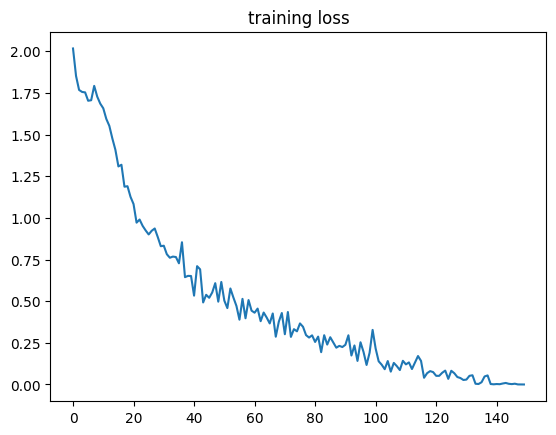

In [20]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.title("training loss")
plt.savefig("/home/kovan2/Desktop/ser/mapped_train_loss.png")

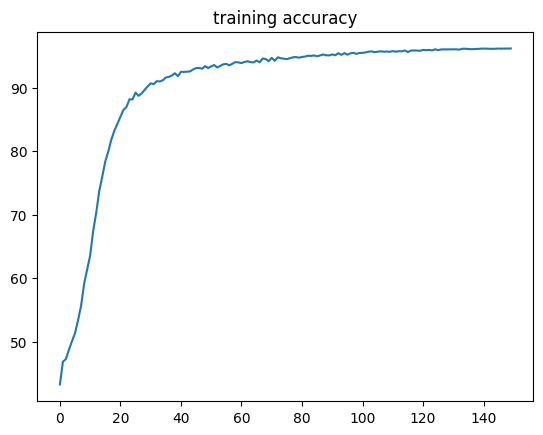

In [21]:
plt.plot(accuracies)
plt.title("training accuracy")
plt.savefig("/home/kovan2/Desktop/ser/mapped_train_acc.png")

***save and load the model***

In [22]:
torch.save(modifiedAlexNet, '/home/kovan2/Desktop/ser/mapped_spec_model.pt')
model=torch.load('/home/kovan2/Desktop/ser/mapped_spec_model.pt')
model.eval()
model.to('cpu')

ModifiedAlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=256, out_features=4, bias=True)
  )
  (softmax): Softmax(dim=1)
)

***testing lopp***

In [23]:
y_actu=[]
y_pred=[]
for every_test_list in test_list:
    label1=every_test_list['label']
    label1=torch.tensor([label1])
    sprectrome=every_test_list['sprectrome']
    with torch.no_grad():
      if(sprectrome.shape[2]>65):
        #sprectrome = sprectrome.to('cuda')
        #label1=label1.to('cuda')
        output = model(sprectrome)
        _, preds = torch.max(output, 1)
        y_actu.append(label1.numpy()[0])
        y_pred.append(preds.numpy()[0])

***confusionMatrix***

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm=confusion_matrix(y_actu, y_pred)
print(cm)

[[169  54  21  54]
 [ 80  43  10  29]
 [ 18   4  58  24]
 [ 51  24  15  68]]


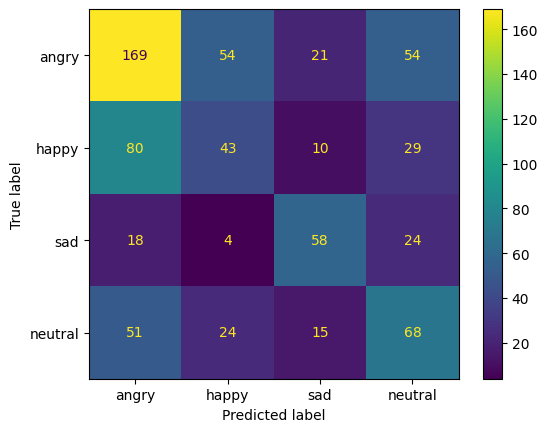

<Figure size 640x480 with 0 Axes>

In [27]:
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["angry","happy","sad","neutral"])
disp.plot()
plt.show()
plt.savefig('/home/kovan2/Desktop/ser/mapped_conf_mat.png')

In [28]:
score=0.0
for i in range(len(y_actu)):
    if y_actu[i]==y_pred[i]:
        score+=1.0
print("Test accuracy:",(score/len(test_list))*100)
print(y_actu,y_pred)

Test accuracy: 45.12683578104139
[0, 0, 1, 3, 1, 3, 3, 3, 0, 3, 0, 3, 0, 0, 2, 0, 0, 0, 3, 1, 0, 0, 3, 0, 2, 0, 0, 2, 0, 2, 1, 3, 0, 2, 2, 2, 1, 3, 2, 0, 0, 1, 3, 2, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 3, 0, 0, 0, 2, 3, 1, 0, 0, 2, 3, 0, 2, 1, 0, 1, 0, 2, 1, 2, 0, 0, 1, 1, 1, 1, 0, 3, 0, 0, 0, 0, 0, 3, 0, 3, 1, 1, 3, 1, 0, 2, 2, 2, 0, 0, 1, 0, 0, 3, 1, 0, 0, 3, 0, 3, 0, 3, 3, 2, 1, 3, 0, 2, 0, 3, 2, 1, 2, 1, 2, 0, 0, 1, 3, 2, 1, 2, 3, 2, 1, 1, 0, 3, 0, 2, 3, 1, 3, 1, 3, 1, 0, 0, 1, 0, 3, 3, 0, 1, 2, 1, 3, 1, 0, 2, 0, 1, 3, 0, 0, 1, 1, 0, 0, 0, 1, 3, 2, 0, 3, 2, 0, 2, 0, 0, 0, 0, 3, 3, 0, 2, 0, 0, 2, 3, 1, 2, 0, 0, 1, 2, 0, 0, 1, 1, 0, 3, 2, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 2, 1, 0, 0, 3, 0, 3, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 1, 2, 3, 1, 0, 3, 3, 3, 3, 0, 0, 2, 0, 3, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 3, 2, 2, 3, 3, 0, 0, 3, 0, 3, 1, 3, 0, 0, 0, 1, 3, 0, 1, 2, 0, 3, 2, 3, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 3, 0, 0, 0, 1, 1, 3, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 3, 0, 0, 0, 2, 0, 1, 1, 2, 